In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats as st
from pybaselines import whittaker
from scipy.fft import fft
from statsmodels.regression.linear_model import yule_walker
import heartpy as htp
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings('ignore')
import pywt
from scipy import ndimage
from datetime import datetime
import time


from itertools import cycle

from xgboost import XGBRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score, RepeatedKFold, KFold
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

C:\Users\smaslikhov\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\smaslikhov\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\smaslikhov\Anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
get_nodefect_dataset()

In [6]:
def calc_baseline(signal):
    """
    Calculate the baseline of signal.
    Args:
        signal (numpy 1d array): signal whose baseline should be calculated
    Returns:
        baseline (numpy 1d array with same size as signal): baseline of the signal
    """
    ssds = np.zeros((3))

    cur_lp = np.copy(signal)
    iterations = 0
    while True:
        # Decompose 1 level
        lp, hp = pywt.dwt(cur_lp, "db4")
        if iterations > 250:
            print('r')
            return whittaker.iasls(signal)[0]
        

        # Shift and calculate the energy of detail/high pass coefficient
        ssds = np.concatenate(([np.sum(hp ** 2)], ssds[:-1]))

        # Check if we are in the local minimum of energy function of high-pass signal
        if ssds[2] > ssds[1] and ssds[1] < ssds[0]:
            break

        cur_lp = lp[:]
        iterations += 1

    # Reconstruct the baseline from this level low pass signal up to the original length
    baseline = cur_lp[:]
    for _ in range(iterations):
        baseline = pywt.idwt(baseline, np.zeros((len(baseline))), "db4")

    return baseline[: len(signal)]

def get_gaussian(sigRate=1000, fwhm=1000, k=500):
    gauss_time = np.arange(-k,k)
    # create Gaussian window
    gauswin = np.exp( -(4*np.log(2)*gauss_time**2) / fwhm**2 )

    pstPeakHalf = k + np.argmin( (gauswin[k:]-.5)**2 )
    prePeakHalf = np.argmin((gauswin-.5)**2)
    empFWHM = gauss_time[pstPeakHalf] - gauss_time[prePeakHalf]

    gauss_win = np.exp(-(4*np.log(2)*gauss_time**2) / empFWHM**2 ) 
    return gauss_win / np.sum(gauss_win)


def filt_signal(signal_mx, width, mode='mov_avg'):
    if mode == 'move_avg':
        return ndimage.convolve(signal_mx, (np.ones(width)/width).reshape(1, -1))
    return ndimage.convolve(signal_mx, get_gaussian(fwhm=width, k=int(width*1.5)).reshape(1, -1))

# def gauss(signal, width):
#     gauss_win = get_gaussian(fwhm=width, k=int(width*1.5))
#     return np.convolve(np.array(signal), gauss_win, mode='valid') 

# def mov_avg(signal, width):
#     return np.convolve(np.array(signal), np.ones(width)/width, mode='valid')

def scale(signal, mode):
    if mode == 'als':
        return signal - whittaker.iasls(signal)[0]
    return signal - calc_baseline(signal)
    
def gauss_and_als(signal, width):
    gauss_win = get_gaussian(fwhm=width, k=int(width*1.5))
    filt_sig = np.convolve(np.array(signal), gauss_win, mode='valid')
    return filt_sig - whittaker.iasls(filt_sig)[0]

def KTE(x, q=1, s=-1):
    
    iedges = abs(q) + abs(s)
    n = np.arange(iedges + 1, (x.shape[1] - iedges - 1))
    return (x[:, n]**2 - x[:, n-q] * x[:, n-s])

def get_frames(signal, sec_width, inersection=0.5, normalize=True):
    width_in_pts = sec_width * 1000
    pts_to_delete = len(signal) % width_in_pts
    signal = signal[pts_to_delete // 2: len(signal) -pts_to_delete + (pts_to_delete // 2)]
    partition_length = width_in_pts // 2
    first_partition = signal[:partition_length].reshape(-1, partition_length)
    last_partition = signal[-partition_length:].reshape(-1, partition_length)
    signal_core = signal[partition_length:-partition_length].reshape(-1, partition_length)
    shifted_up = np.vstack([first_partition, signal_core])
    shifted_down = np.vstack([signal_core, last_partition])
    frames = np.hstack([shifted_up, shifted_down])
    if normalize:
        return frames / np.sum(frames, axis=1).reshape(len(frames), -1)
    return frames

def calculate_entropy(frames):
    return np.sum(frames * np.log(frames), axis=1)

def get_AR_coeffs_from_mx(signal_matrix):
    ar_coefs = []
    for signal in signal_matrix:
        try:
            ar_coefs.append(yule_walker(signal, order=5)[0])
        except:
            ar_coefs.append([-1]*5)
    return np.array(ar_coefs)
#     return np.array(list(map(lambda x: yule_walker(x, order=5)[0], signal_matrix)))

def get_ar_names(feature, order=5):
    return [f'AR_{feature}_{i + 1}' for i in range(order)]

def get_hr(signal_matrix):
    hr_chars = []
    for signal in signal_matrix:
        try:
            hr_chars.append(list(htp.process(signal, sample_rate = 1000)[1].values()))
        except:
            hr_chars.append([-1]*13)
    return np.array(hr_chars)

In [6]:
def get_scaled_encoded_df(df, numeric_features, cat_features, encode=True):
    #MinMaxScaller
    numeric_data = df[numeric_features].applymap(float)
    scaled_numeric_features = (numeric_data - numeric_data.min()) / (numeric_data.max() - numeric_data.min())
    if encode and len(cat_features):
        one_hot = pd.get_dummies(df[cat_features])
        return scaled_numeric_features.join(one_hot)
    else:
        return scaled_numeric_features.join(df[cat_features])

In [7]:
def features_calc_to_csv(name_df, signal_name, chunksize, frame_width=5):
    hr_names = ['bpm', 'ibi', 'sdnn', 'sdsd', 'rmssd', 'pnn20', 'pnn50', 
                'hr_mad', 'sd1', 'sd2', 's', 'sd1/sd2', 'breathingrate']
    df_columns = pd.read_csv(f'{name_df}.csv', nrows=2).columns
    with pd.read_csv(f'{name_df}.csv', chunksize=chunksize) as reader:
        for i, chunk in enumerate(reader):
            chunk.columns = df_columns
            chunk = chunk.dropna()
            chunk = chunk[chunk[signal_name] != '[]']
            # signal extracting and preprocessing
            chunk[signal_name] = chunk[signal_name].apply(lambda x: np.array(list(map(float, x.strip('][').split(',')))))
            # check for correct length of signal
            chunk = chunk[chunk[signal_name].apply(len) >= 10000]
#             if get_informative_part:
            infomative_signal = []
            for signal in chunk[signal_name].tolist():
                frames = get_frames(signal, 10, normalize=False)
                frames_KTE = KTE(frames)
                best_frame_num = np.argmax(np.mean(frames_KTE, axis=1))
                infomative_signal.append(frames[best_frame_num, :])
            preprocessed_signal = np.array(infomative_signal)
#             if preprocess:
#                 preprocessed_signal = filt_signal(np.array(chunk[signal_name].tolist()), width=filt_width, mode=filt_nm)
#                 if scale_nm:
#                     preprocessed_signal = np.array(list(map(lambda x: scale(x, mode=scale_nm), preprocessed_signal)))
#             else:
#                 preprocessed_signal = np.array(chunk[signal_name].tolist())
            print(preprocessed_signal.shape)
            chunk[get_ar_names('PPG')] = get_AR_coeffs_from_mx(preprocessed_signal)
            chunk.drop(labels=signal_name, axis='columns', inplace=True)
            # calculation of KTE and its characteristics
            KTE_mx = KTE(preprocessed_signal)
            chunk[get_ar_names('KTE')] = get_AR_coeffs_from_mx(KTE_mx)
            chunk['KTE_mean'] = np.mean(KTE_mx, axis=1)
            chunk['KTE_std'] = np.std(KTE_mx, axis=1)
            chunk['KTE_skew'] = st.skew(KTE_mx, axis=1)
            chunk['KTE_iqr'] = st.iqr(KTE_mx, axis=1)
            # calculation of entropy and its characteristics
            entropies = []
            fft_signal = fft(preprocessed_signal)
            squared_abs = np.abs(fft_signal)**2
            for signal in squared_abs:
                frames = get_frames(signal, frame_width)
                entropies.append(calculate_entropy(frames))
            entropies_mx = np.array(entropies)
            chunk['entropy_mean'] = np.mean(entropies_mx, axis=1)
            chunk['entropy_std'] = np.std(entropies_mx, axis=1)
            chunk['entropy_skew'] = st.skew(entropies_mx, axis=1)
            chunk['entropy_iqr'] = st.iqr(entropies_mx, axis=1)
            # calculation of spectral energy and its characteristics
            spectral_energies = []
            for signal in preprocessed_signal:
                frames = get_frames(signal, frame_width, normalize=False)
                spectral_energies.append(np.log(np.sum(frames**2, axis=1)))
            spectral_energies_mx = np.array(spectral_energies)
            chunk[get_ar_names('spectral_energy')] = get_AR_coeffs_from_mx(spectral_energies_mx)
            chunk['spectral_energy_mean'] = np.mean(spectral_energies_mx, axis=1)
            chunk['spectral_energy_std'] = np.std(spectral_energies_mx, axis=1)
            chunk['spectral_energy_skew'] = st.skew(spectral_energies_mx, axis=1)
            chunk['spectral_energy_iqr'] = st.iqr(spectral_energies_mx, axis=1)
            # hr characteristics
            chunk[hr_names] = get_hr(preprocessed_signal)
            if i == 0:
                chunk.to_csv(f'{name_df}_features_calc.csv', index=False, mode='a')
            else:
                chunk.to_csv(f'{name_df}_features_calc.csv', header=False, index=False, mode='a')
#             if i % 2 == 0:
#                 print(i)

In [38]:
def analyze_filt_width_and_feature_importance(frame_width=2, chunksize=500, df_name='fasting'):
    features_calc_to_csv(df_name, 'ppg_data', chunksize, frame_width=frame_width)
    df_fasting = pd.read_csv(f'{df_name}_features_calc.csv')
#         df_fasting = df_fasting[df_fasting['s'].apply(float) != -1]
    df_fasting = df_fasting.iloc[:, :-13].dropna()
    cols_to_drop = ['cid', 'glu']
    cat_features = []
    y_fasting = df_fasting['glu']
    df_fasting_core = df_fasting.drop(labels=cols_to_drop, axis='columns')
    numeric_features =  list(set(df_fasting_core.columns).difference(set(cat_features)))
    fasting_encoded = get_scaled_encoded_df(df_fasting_core, numeric_features, cat_features)
    print(f'Non null object count: {len(fasting_encoded)}')
    print(f'RMSE: {-cross_val_score(SVR(), fasting_encoded, y_fasting, scoring="neg_root_mean_squared_error", cv=5).mean():.3f}')
    print(f'R2: {cross_val_score(SVR(), fasting_encoded, y_fasting, scoring="r2", cv=5).mean():.3f}')

In [39]:
analyze_filt_width_and_feature_importance(chunksize=200, df_name='nodefect_ppg')

(199, 10000)
(199, 10000)
(200, 10000)
(200, 10000)
(200, 10000)
(200, 10000)
(199, 10000)
(200, 10000)
(200, 10000)
(200, 10000)
(199, 10000)
(200, 10000)
(200, 10000)
(145, 10000)
Non null object count: 1564
RMSE: 3.642
R2: -0.255


In [72]:
df_all = pd.read_csv(f'nodefect_ppg_features_calc.csv')
#         df_fasting = df_fasting[df_fasting['s'].apply(float) != -1]
df_all = df_all.iloc[:, :-13].dropna()
cols_to_drop = ['cid', 'glu']
cat_features = []
y_all = df_all['glu']
df_all_core = df_all.drop(labels=cols_to_drop, axis='columns')
numeric_features =  list(set(df_all_core.columns).difference(set(cat_features)))
fasting_encoded = get_scaled_encoded_df(df_all_core, numeric_features, cat_features)
print(f'Non null object count: {len(fasting_encoded)}')
print(f'RMSE: {-cross_val_score(SVR(), fasting_encoded, y_all, scoring="neg_root_mean_squared_error", cv=5).mean():.3f}')
print(f'R2: {cross_val_score(SVR(), fasting_encoded, y_all, scoring="r2", cv=5).mean():.3f}')

Non null object count: 2741
RMSE: 3.581
R2: -0.210


(array([329., 966., 608., 387., 239., 132.,  48.,  27.,   4.,   1.]),
 array([ 2.7 ,  4.96,  7.22,  9.48, 11.74, 14.  , 16.26, 18.52, 20.78,
        23.04, 25.3 ]),
 <BarContainer object of 10 artists>)

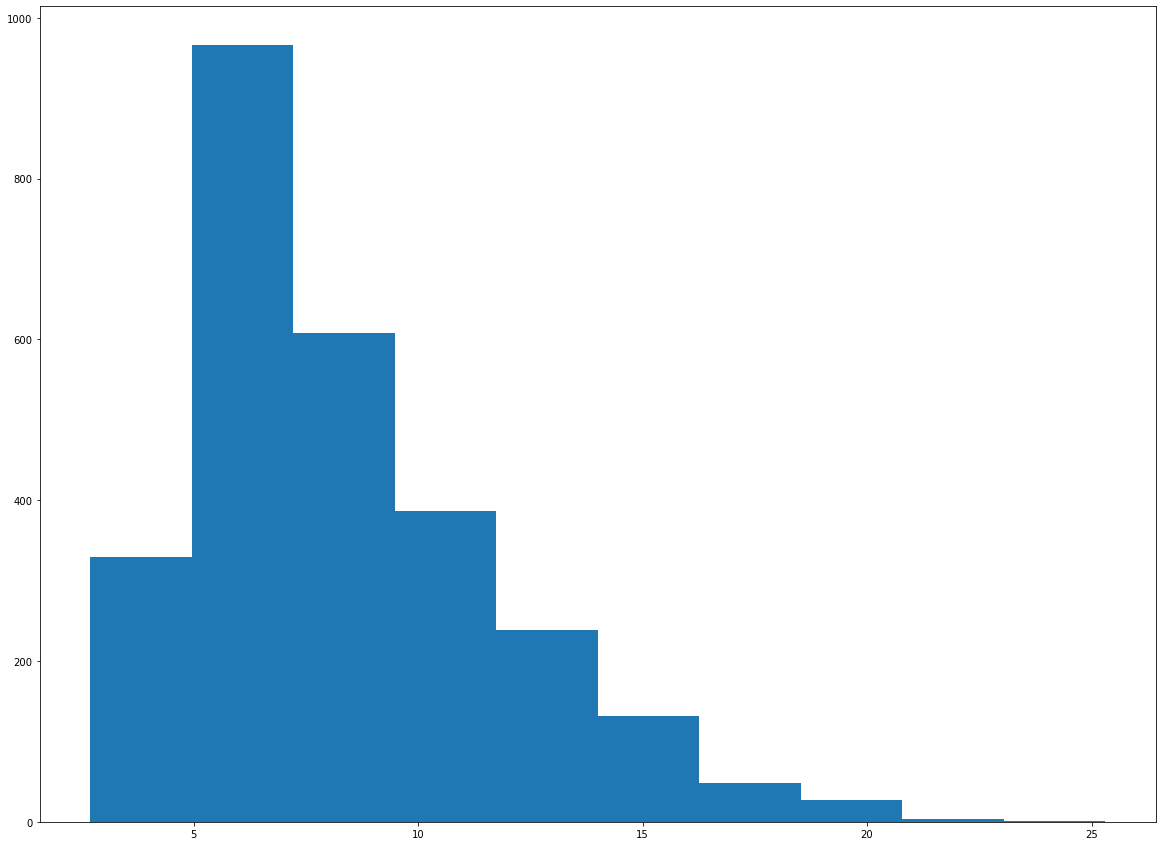

In [82]:
plt.figure(figsize=(20, 15))
plt.hist(df_all['glu'])

In [76]:
df_all.corr()['glu']

cid                    -0.262660
glu                     1.000000
AR_PPG_1               -0.023365
AR_PPG_2                0.024364
AR_PPG_3               -0.031696
AR_PPG_4                0.026680
AR_PPG_5               -0.009227
AR_KTE_1                0.012506
AR_KTE_2                0.035401
AR_KTE_3                0.032441
AR_KTE_4                0.032666
AR_KTE_5                0.025365
KTE_mean               -0.004016
KTE_std                -0.004894
KTE_skew               -0.001849
KTE_iqr                 0.002134
entropy_mean            0.018753
entropy_std             0.005704
entropy_skew            0.009233
entropy_iqr             0.034263
AR_spectral_energy_1    0.013585
AR_spectral_energy_2    0.024071
AR_spectral_energy_3    0.006189
AR_spectral_energy_4    0.028557
AR_spectral_energy_5    0.012842
spectral_energy_mean   -0.014885
spectral_energy_std    -0.029620
spectral_energy_skew    0.022816
spectral_energy_iqr    -0.018251
Name: glu, dtype: float64

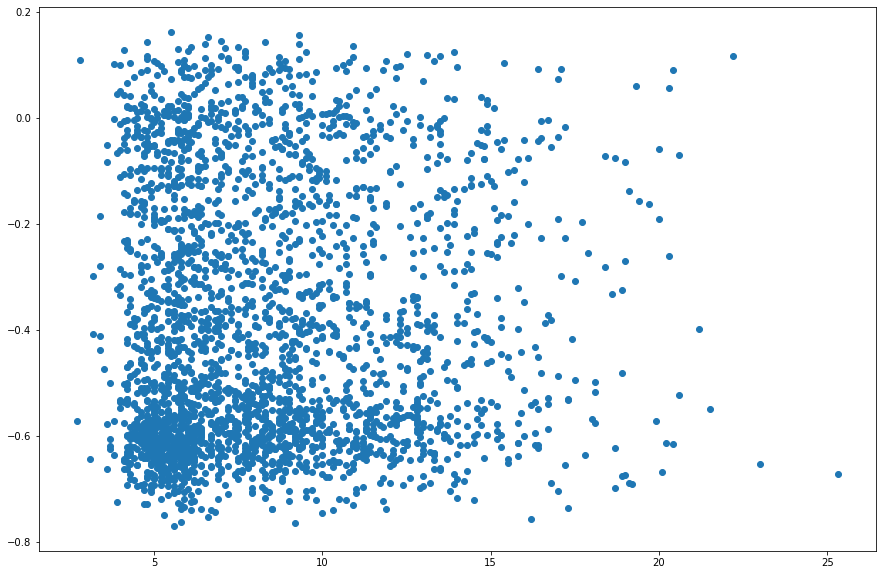

In [78]:
plt.figure(figsize=(15, 10))
plt.scatter(df_all['glu'], df_all['AR_KTE_2'])

In [44]:
df_fasting = pd.read_csv(f'PPG_Polyclininc_nodefect_features_calc.csv')
#         df_fasting = df_fasting[df_fasting['s'].apply(float) != -1]
df_fasting = df_fasting.iloc[:, :-13].dropna()
cols_to_drop = ['cid', 'glu', 'rate', 'otvedenie']
cat_features = []
y_fasting = df_fasting['glu']
df_fasting_core = df_fasting.drop(labels=cols_to_drop, axis='columns')
numeric_features =  list(set(df_fasting_core.columns).difference(set(cat_features)))
fasting_encoded = get_scaled_encoded_df(df_fasting_core, numeric_features, cat_features)
print(f'Non null object count: {len(fasting_encoded)}')
print(f'RMSE: {-cross_val_score(SVR(), fasting_encoded, y_fasting, scoring="neg_root_mean_squared_error", cv=5).mean():.3f}')
print(f'R2: {cross_val_score(SVR(), fasting_encoded, y_fasting, scoring="r2", cv=5).mean():.3f}')

Non null object count: 179
RMSE: 0.841
R2: 0.032


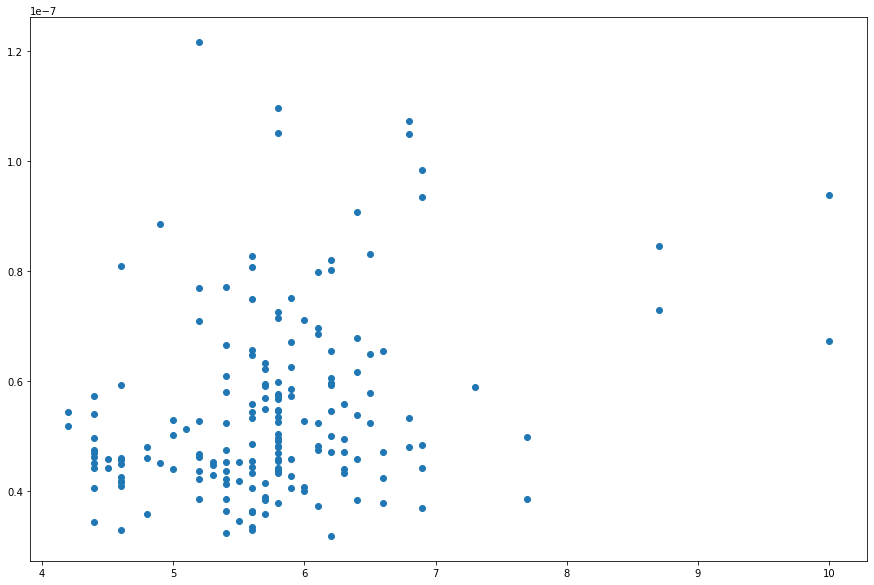

In [73]:
plt.figure(figsize=(15, 10))
plt.scatter(df_fasting['glu'], df_fasting['KTE_mean'])

In [67]:
df_fasting.corr()['glu']

cid                    -0.064139
duration                0.069706
rate                         NaN
glu                     1.000000
AR_PPG_1                0.316761
AR_PPG_2               -0.098676
AR_PPG_3                0.279459
AR_PPG_4               -0.153590
AR_PPG_5               -0.302322
AR_KTE_1                0.009373
AR_KTE_2               -0.074535
AR_KTE_3               -0.016810
AR_KTE_4               -0.049805
AR_KTE_5               -0.089709
KTE_mean                0.305550
KTE_std                 0.264715
KTE_skew                0.168456
KTE_iqr                 0.223723
entropy_mean           -0.030837
entropy_std             0.020283
entropy_skew            0.002371
entropy_iqr            -0.103272
AR_spectral_energy_1    0.024597
AR_spectral_energy_2   -0.025749
AR_spectral_energy_3    0.026188
AR_spectral_energy_4   -0.020670
AR_spectral_energy_5    0.023929
spectral_energy_mean    0.266847
spectral_energy_std    -0.207845
spectral_energy_skew   -0.050283
spectral_e

In [68]:
X_new = SelectKBest(f_regression, k=6).fit_transform(fasting_encoded, y_fasting)

In [69]:
cross_val_score(XGBRegressor(), X_new, y_fasting, scoring="r2", cv=5).mean()

-0.12420518888170973

In [3]:
df_fasting = pd.read_csv('fasting.csv')

In [17]:
one_patient_als = df_fasting[(df_fasting['cid'] == 158033) | (df_fasting['cid'] == 158030) | (df_fasting['cid'] ==  157688)]['ppg_data'].apply(lambda x: np.array(list(map(float, x.strip('][').split(','))))).to_list()

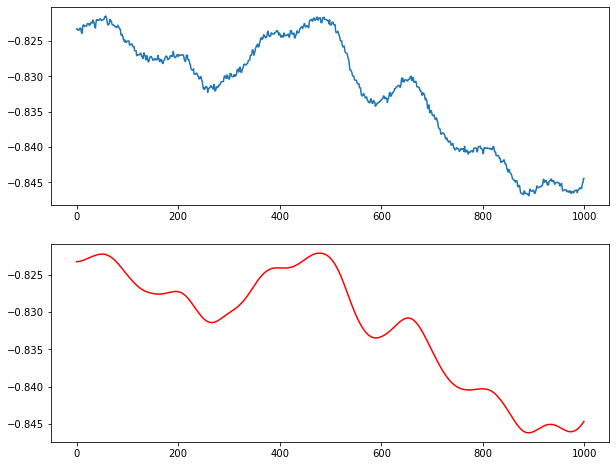

In [40]:
fig = plt.figure( figsize=(10, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
ax1.plot(one_patient_als[0][:1000] )
ax2.plot(one_patient_al[0][:1000], color='r', )

In [39]:
one_patient_al = filt_signal(np.array(one_patient_als), width=30, mode='mov_avg')
# one_patient_als = np.array(list(map(lambda x: scale(x, mode='als'), one_patient_als)))

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_patient = scaler.fit_transform(one_patient_als.T)

In [12]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
minmax_patient = minmax.fit_transform(one_patient_als.T)

In [178]:
np.mean(KTE(one_patient_als), axis=1)

array([1.03244082e-08, 5.75750779e-09, 2.27641603e-08])

In [187]:
np.mean(KTE(scaled_patient.T), axis=1)

array([0.00038498, 0.00031496, 0.00029848])

In [188]:
np.mean(KTE(minmax_patient.T), axis=1)

array([3.19374252e-06, 1.62299559e-05, 2.05804649e-05])

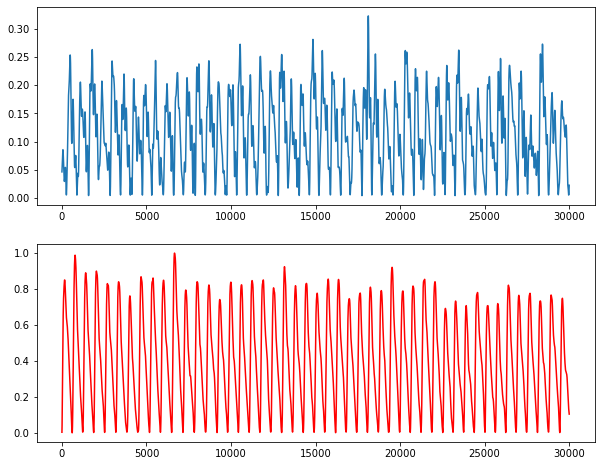

In [16]:
fig = plt.figure( figsize=(10, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
ax1.plot(minmax_patient[:30000, 0] )
ax2.plot(minmax_patient[:30000, 1], color='r', )

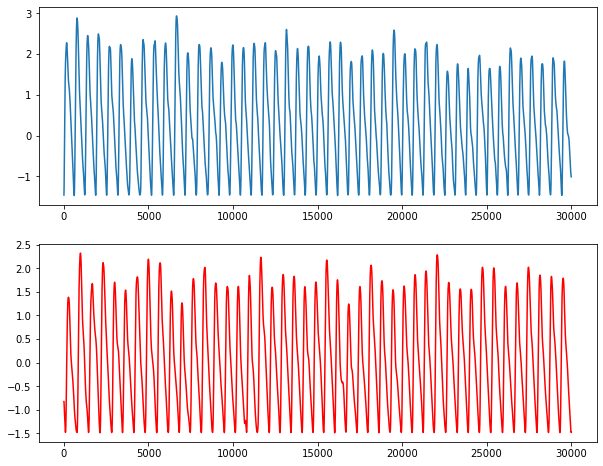

In [11]:
fig = plt.figure( figsize=(10, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
ax1.plot(scaled_patient[:30000, 1] )
ax2.plot(scaled_patient[:30000, 2], color='r', )

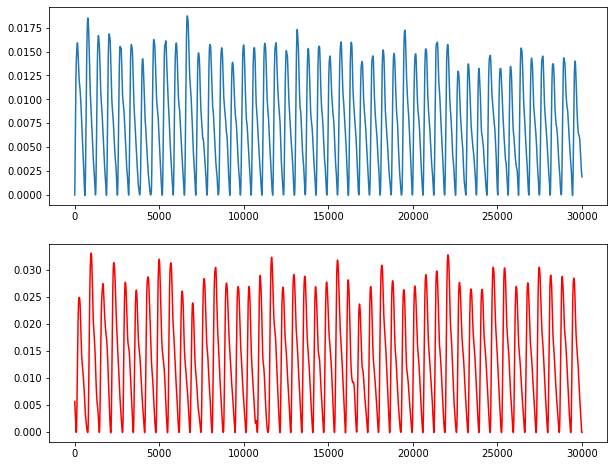

In [9]:
# df_ppg = pd.read_csv('nodefect_ppg.csv')
# one_patient = df_ppg[(df_ppg['cid'] == 158033) | (df_ppg['cid'] == 158030)]['ppg_data'].apply(lambda x: np.array(list(map(float, x.strip('][').split(','))))).to_list()
fig = plt.figure( figsize=(10, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
ax1.plot(one_patient_als[1][:30000])
ax2.plot(one_patient_als[2][:30000], color='r' )

*План работ*
* Добавить в файлы столбцы с рассчитанными фичами
* Провести расчет на выборке одной из успешных работ
* Проверить разбиение по: диабетикам (0 и 1,2), натощак\ненатощак, по площадкам, по возрасту (до 44, 45-64, 64+), полу
* Брать только 1 из снятых ФПГ по пациенту в поликлинике
* Попробовать отнормировать по амплитуде